# Congressional Speech Analysis


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.max_columns = 1200  
pd.options.display.max_rows = 1200 

import unicodedata
import itertools
import datetime
import datefinder
import operator
import string
import re

import nltk
from nltk.tokenize import sent_tokenize

def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

### Get files

The first step is to generate the data frame of all 114th Congress hearings. The files are contained in directories following this structure:

Data ---> Congress ---> Office ---> Department ---> Text files in txt format.

Each text file is imported into the documents column of the data frame and assigned a document ID.


In [4]:
from IPython.display import clear_output

FILES_PATH = '/home/yuver/academico/data/'

congresses = sorted(listdir_nohidden(FILES_PATH))

congressional_hearings = []

for congress in congresses:
    clear_output()
    print(f'Now loading congress {congress}')
    offices = listdir_nohidden(congress)
    for office in offices:
        clear_output()
        print(f'Now loading office {office}')
        congress = os.path.split(os.path.dirname(office))[1]
        departments = listdir_nohidden(office)
        for department in departments:
            clear_output()
            office = os.path.split(os.path.dirname(department))[1]
            try:
                session_files = listdir_nohidden(department)
            except:
                print(f'No txt files for session {session}')
                continue

            txt_files = [f for f in session_files if f.endswith('.txt')]
            for file in txt_files:
                with open(file, errors='replace') as f:
                    document = f.read().lower() 
                    _department = os.path.split(os.path.dirname(file))[1]
                    name = os.path.basename(file)
                    congressional_hearings.append([document, congress, office, _department, name])
            
clear_output()
print('Done')

congressional_hearings_df = pd.DataFrame(congressional_hearings).reset_index().rename(columns={'index': 'document_id'})
congressional_hearings_df.columns = ['document_id', 'document', 'congress','office','department','name']
congressional_hearings_df = congressional_hearings_df.sort_values(by=['congress', 'office','department','name'])

print(f'Congressional Hearings DF shape: {congressional_hearings_df.shape}')
congressional_hearings_df.head()

Done
Congressional Hearings DF shape: (2535, 6)


,document_id,document,congress,office,department,name
1873,1873,\n - eastern mediterranean energy: challenges ...,114th,house,Ad Hoc Committee on Energy,1.txt
1075,1075,\n - [errata] manipulation and fraud in the re...,114th,house,Commission on Security and Cooperation in Europe,1.txt
1078,1078,\n - the rule of law and civil society in azer...,114th,house,Commission on Security and Cooperation in Europe,2.txt
1079,1079,\n - human rights violations in russian-occupi...,114th,house,Commission on Security and Cooperation in Europe,3.txt
1077,1077,\n - nato's warsaw summit and the future of eu...,114th,house,Commission on Security and Cooperation in Europe,4.txt


In [10]:
len(congressional_hearings_df.document[0])

145869

### Get sentences

Extract the data frame of sentences for each document with respective sentence ID and speaker name. Match speaker names extracted from the hearings documents with the complete list of speakers extracted from the bills data frame.

In [12]:
FILE_PATH = '/home/yuver/academico/data/congress_114_bills_df_new.xlsx'
congress_114_df_new = pd.read_excel(FILE_PATH)  

In [17]:
congress_114_df_new.shape

(3886, 25)

In [22]:
congress_114_df_new.describe()

,sentence_id,bill_id,PassH,PassS,unique_sentence_id,document_id,speech_id,unique_speech_id,speech_len,sentence_len,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
count,3.886000e+03,3886.000000,3808.000000,3808.000000,3.886000e+03,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000
mean,8.982784e+05,2161.696603,0.306460,0.085609,8.982784e+05,1339.011580,415.205353,160869.183736,1076.825528,22.020844,0.027690,0.845653,0.126658,0.360553
std,4.972900e+05,1569.287672,0.461084,0.279823,4.972900e+05,721.380582,439.841936,93660.323522,1490.696409,22.736323,0.056356,0.108199,0.101356,0.419791
min,1.576000e+03,1.000000,0.000000,0.000000,1.576000e+03,0.000000,1.000000,81.000000,10.000000,4.000000,0.000000,0.402000,0.000000,-0.986400
25%,4.456660e+05,766.000000,0.000000,0.000000,4.456660e+05,666.000000,106.000000,75899.000000,293.250000,8.000000,0.000000,0.775000,0.048000,0.000000
50%,9.299115e+05,1957.000000,0.000000,0.000000,9.299115e+05,1415.000000,253.000000,155187.000000,667.000000,16.000000,0.000000,0.852000,0.115000,0.428600
75%,1.378828e+06,3070.000000,1.000000,0.000000,1.378828e+06,1940.000000,597.000000,241405.500000,952.500000,28.000000,0.036000,0.924000,0.192000,0.709600
max,1.693597e+06,12259.000000,1.000000,1.000000,1.693597e+06,2533.000000,2623.000000,321574.000000,17559.000000,361.000000,0.472000,1.000000,0.526000,0.987100


<AxesSubplot:>

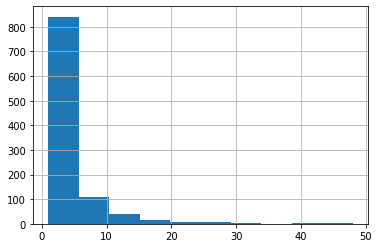

In [25]:
congress_114_df_new.bill_id.value_counts().hist()